# Load libraries

In [9]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib scikit-learn seaborn umap-learn scipy xgboost shap PyALE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 5.8 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 21.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [15]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps  # Ensure this is imported
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
import math
import json
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import shap
from PyALE import ale
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import linregress, spearmanr

# Loading the data

In [30]:
chamau_lag = pd.read_csv("../datasets/Chamau_2014-2024_clean.csv")
chamau_daily = pd.read_csv("../datasets/Chamau_Daily_2014-2024.csv")
oensingen_1_lag = pd.read_csv("../datasets/Oensingen_2018-19_clean.csv")
oensingen_1_daily = pd.read_csv("../datasets/Oensingen_Daily_2018-19.csv")
oensingen_2_lag = pd.read_csv("../datasets/Oensingen_2021-23_clean.csv")
oensingen_2_daily = pd.read_csv("../datasets/Oensingen_Daily_2021-23.csv")
aeschi_lag = pd.read_csv("../datasets/Aeschi_2019-20_clean.csv")
aeschi_daily = pd.read_csv("../datasets/Aeschi_Daily_2019-20.csv")

# Experiment 1: Oensingen 2021-23

# Experiment 2: Oensingen 2018-19

In [ ]:
def train_xgb_timeseries(df, predictors, target, test_size=0.3, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.2f}, ρ={rho:.2f})")
        axes[0].grid(True, alpha=0.3)
        
        # Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
    }

# Experiment 3: Aeschi dataset

In [24]:
# FIX TIMESTAMP
aeschi_lag['Timestamp'] = pd.to_datetime(aeschi_lag['Timestamp'])
aeschi_lag = aeschi_lag.set_index('Timestamp').sort_index()

aeschi_daily['Date'] = pd.to_datetime(aeschi_daily['Date'])
aeschi_daily = aeschi_daily.set_index('Date').sort_index()

# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO", "Mowing"
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing"
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_5cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": aeschi_lag,
    "Daily": aeschi_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [26]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.7)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-0.638, ρ=-0.366

Hourly | N2O_Flux | lag
  R²=-1.466, ρ=0.013

Hourly | N2O_Flux | main
  R²=-0.731, ρ=-0.248

Hourly | N2O_Flux_ln | base
  R²=-0.942, ρ=-0.440

Hourly | N2O_Flux_ln | lag
  R²=-2.935, ρ=0.089

Hourly | N2O_Flux_ln | main
  R²=-0.917, ρ=-0.116

Daily | N2O_Flux | base
  R²=-0.370, ρ=-0.379

Daily | N2O_Flux | lag
  R²=-0.968, ρ=-0.615

Daily | N2O_Flux | main
  R²=-0.361, ρ=0.095

Daily | N2O_Flux_ln | base
  R²=-0.226, ρ=-0.152

Daily | N2O_Flux_ln | lag
  R²=-1.073, ρ=-0.503

Daily | N2O_Flux_ln | main
  R²=-0.411, ρ=0.103

=== Summary Results ===
   Dataset       Target Predictors     R2  Spearman
0   Hourly     N2O_Flux       base -0.638    -0.366
1   Hourly     N2O_Flux        lag -1.466     0.013
2   Hourly     N2O_Flux       main -0.731    -0.248
3   Hourly  N2O_Flux_ln       base -0.942    -0.440
4   Hourly  N2O_Flux_ln        lag -2.935     0.089
5   Hourly  N2O_Flux_ln       main -0.917    -0.116
6    Daily     N2O_Flux       b

In [27]:
def train_xgb_timeseries(df, predictors, target, test_size=0.3, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.2f}, ρ={rho:.2f})")
        axes[0].grid(True, alpha=0.3)
        
        # Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
    }

--- Training on aeschi_daily | target=N2O_Flux_ln | predictors=lag ---
Train period: 2019-07-03 00:00:00 → 2020-10-03 00:00:00
Test  period: 2020-10-04 00:00:00 → 2020-11-02 00:00:00

Model evaluation:
  R² (linear scale): -1.073
  Spearman ρ:        -0.503


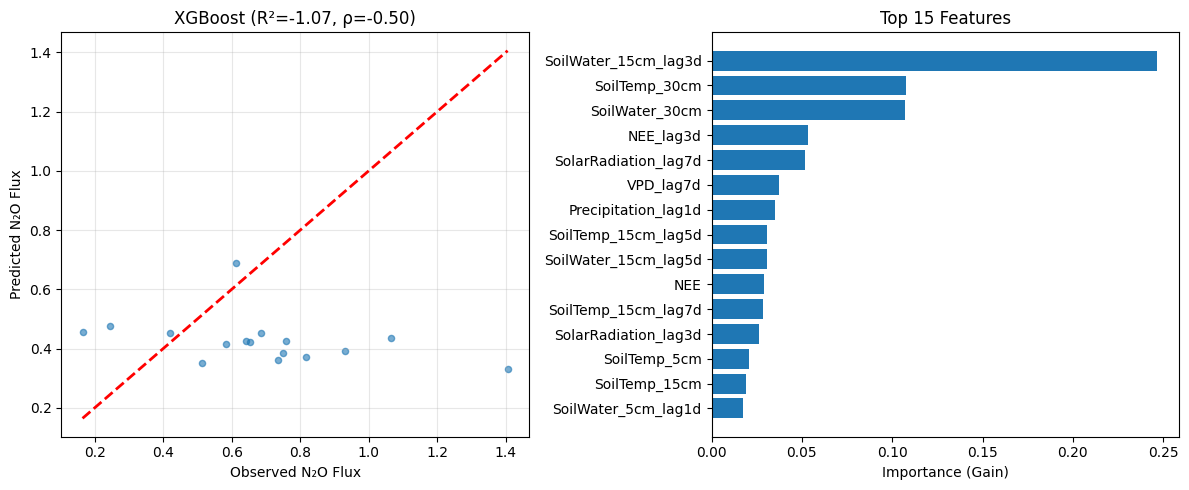


main cols
Train period: 2019-07-03 14:45:00 → 2020-10-10 10:45:00
Test  period: 2020-10-10 11:15:00 → 2020-11-02 17:45:00

Model evaluation:
  R² (linear scale): -0.917
  Spearman ρ:        -0.116


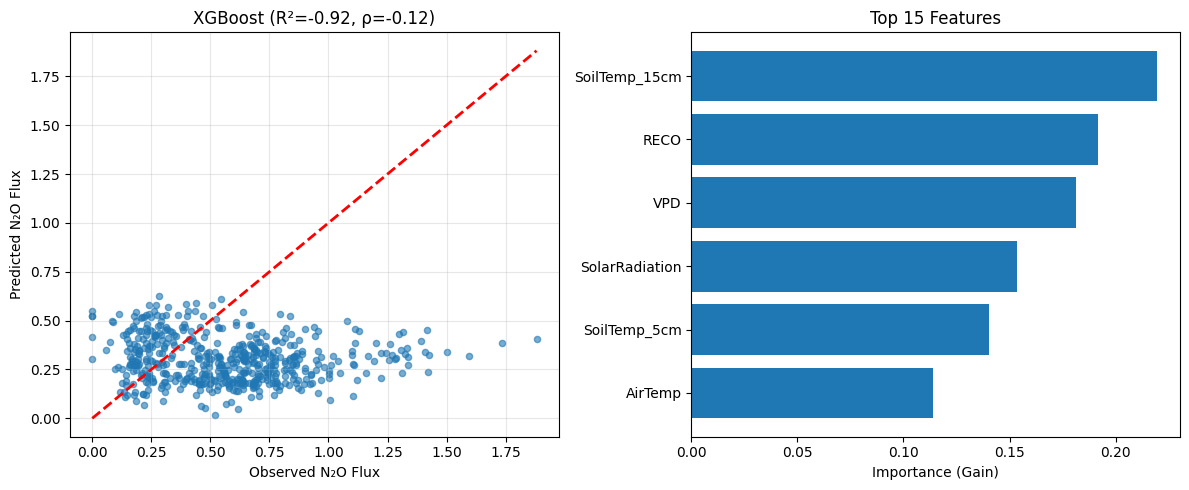


TOP 20 MOST IMPORTANT FEATURES:
SoilTemp_15cm     0.219348
RECO              0.191598
VPD               0.181445
SolarRadiation    0.153534
SoilTemp_5cm      0.140330
AirTemp           0.113746
dtype: float32


In [28]:
# ============================================================================
# TRAINING 1: aeschi_daily with lag features
# ============================================================================

print("--- Training on aeschi_daily | target=N2O_Flux_ln | predictors=lag ---")

results = train_xgb_timeseries(
    df=aeschi_daily,
    predictors=[
        # --- Meteorological base variables ---
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",

        # --- Meteorological lag variables ---
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # --- Management variables ---
        "Mowing",
    ],
    target="N2O_Flux_ln",
)


# ============================================================================
# TRAINING 2: aeschi (hourly) with main columns only
# ============================================================================

print("\nmain cols")
results = train_xgb_timeseries(
    df=aeschi_lag,
    predictors=[
        "AirTemp", "VPD",
        "SoilTemp_5cm", "SoilTemp_15cm",
        "RECO", "SolarRadiation"
    ],
    target="N2O_Flux_ln",
)

# PRINT TOP FEATURES FROM LAST MODEL
print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES:")
print("="*60)
print(results["feature_importance"].head(20))

# Experiment 4: Chamau dataset

In [31]:
# FIX TIMESTAMP
chamau_lag['Timestamp'] = pd.to_datetime(chamau_lag['Timestamp'])
chamau_lag = chamau_lag.set_index('Timestamp').sort_index()

chamau_daily['Date'] = pd.to_datetime(chamau_daily['Date'])
chamau_daily = chamau_daily.sort_values('Date')

# SPLIT BY PARCEL
chamau_A = chamau_lag[chamau_lag['Parcel'] == 'A'].copy()
chamau_B = chamau_lag[chamau_lag['Parcel'] == 'B'].copy()
chamau_daily_A = chamau_daily[chamau_daily['Parcel'] == 'A'].set_index('Date')
chamau_daily_B = chamau_daily[chamau_daily['Parcel'] == 'B'].set_index('Date')

# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation"
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_Grazing", "DaysSince_SoilCultivation"
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_4cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": chamau_lag,
    "Hourly A": chamau_A,
    "Hourly B": chamau_B,
    "Daily A": chamau_daily_A,
    "Daily B": chamau_daily_B,
    "Daily": chamau_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [39]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.7)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-0.060, ρ=0.255

Hourly | N2O_Flux | lag
  R²=-0.191, ρ=0.301

Hourly | N2O_Flux | main
  R²=-0.046, ρ=0.247

Hourly | N2O_Flux_ln | base
  R²=0.069, ρ=0.346

Hourly | N2O_Flux_ln | lag
  R²=0.068, ρ=0.338

Hourly | N2O_Flux_ln | main
  R²=0.004, ρ=0.297

Hourly A | N2O_Flux | base
  R²=0.076, ρ=0.351

Hourly A | N2O_Flux | lag
  R²=0.081, ρ=0.334

Hourly A | N2O_Flux | main
  R²=0.050, ρ=0.267

Hourly A | N2O_Flux_ln | base
  R²=0.140, ρ=0.371

Hourly A | N2O_Flux_ln | lag
  R²=0.030, ρ=0.301

Hourly A | N2O_Flux_ln | main
  R²=0.107, ρ=0.263

Hourly B | N2O_Flux | base
  R²=-0.085, ρ=0.352

Hourly B | N2O_Flux | lag
  R²=-0.076, ρ=0.346

Hourly B | N2O_Flux | main
  R²=-0.118, ρ=0.266

Hourly B | N2O_Flux_ln | base
  R²=0.106, ρ=0.445

Hourly B | N2O_Flux_ln | lag
  R²=0.052, ρ=0.381

Hourly B | N2O_Flux_ln | main
  R²=-0.040, ρ=0.327

Daily A | N2O_Flux | base
  R²=0.144, ρ=0.425

Daily A | N2O_Flux | lag
  R²=0.200, ρ=0.522

Daily A | N2O_Flux | main


In [40]:
def train_xgb_timeseries(df, predictors, target, test_size=0.3, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
    }

--- Training on chamau_daily | target=N2O_Flux_ln | predictors=lag ---
Train period: 0 → 1660
Test  period: 1661 → 2907

Model evaluation:
  R² (linear scale): 0.278
  Spearman ρ:        0.456


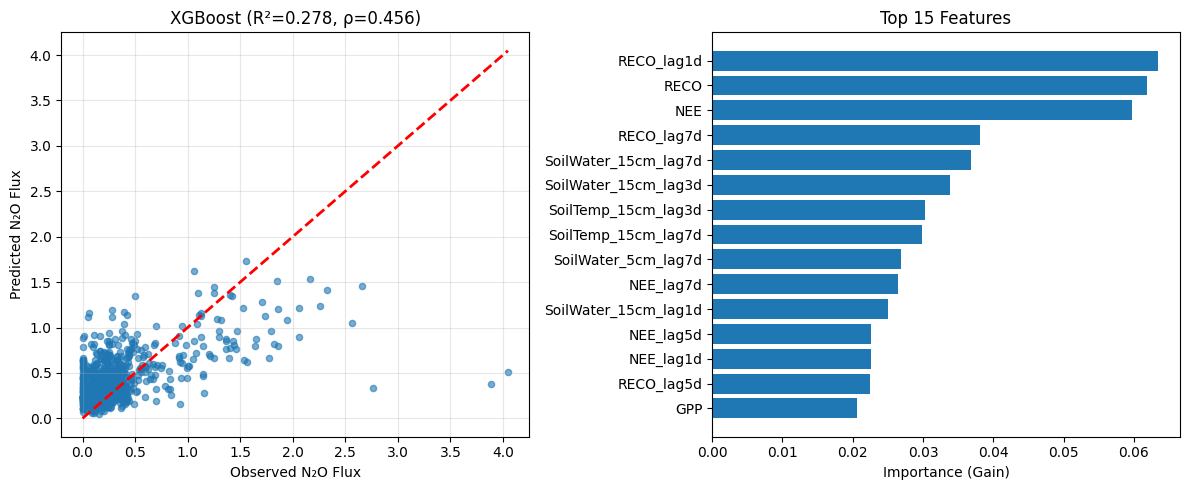


main cols
Train period: 2014-01-01 08:15:00 → 2020-09-23 17:15:00
Test  period: 2020-09-24 03:45:00 → 2022-07-06 09:15:00

Model evaluation:
  R² (linear scale): 0.004
  Spearman ρ:        0.297


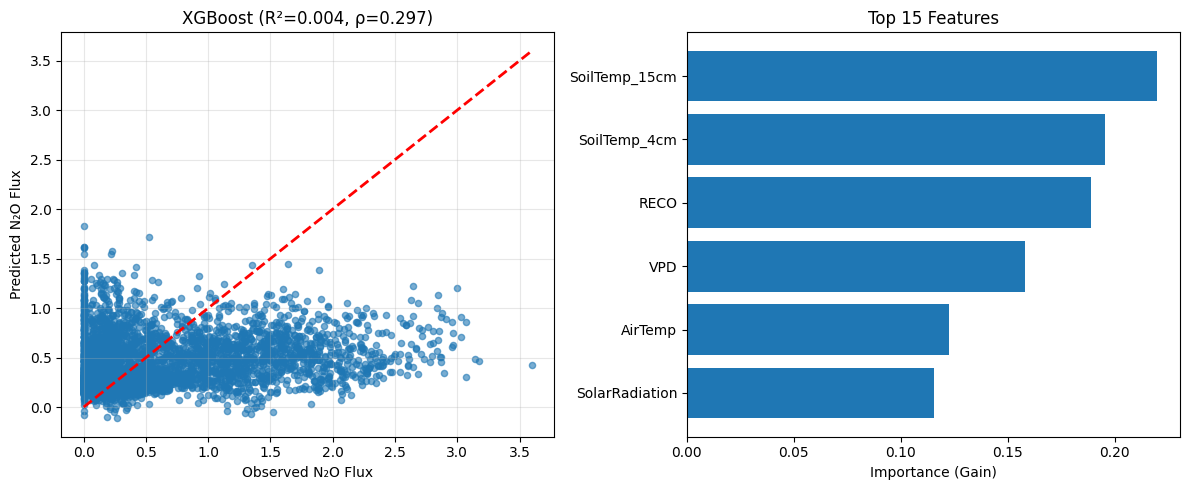


TOP 20 MOST IMPORTANT FEATURES:
SoilTemp_15cm     0.219545
SoilTemp_4cm      0.195618
RECO              0.189003
VPD               0.158132
AirTemp           0.122304
SolarRadiation    0.115398
dtype: float32


In [41]:
# ============================================================================
# TRAINING 1: chamau_daily with lag features
# ============================================================================

print("--- Training on chamau_daily | target=N2O_Flux_ln | predictors=lag ---")

results = train_xgb_timeseries(
    df=chamau_daily,
    predictors=[
        # --- Meteorological base variables ---
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",

        # --- Meteorological lag variables ---
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # --- Management variables ---
        "Mowing",
    ],
    target="N2O_Flux_ln",
)


# ============================================================================
# TRAINING 2: chamau (hourly) with main columns only
# ============================================================================

print("\nmain cols")
results = train_xgb_timeseries(
    df=chamau_lag,
    predictors=[
        "AirTemp", "VPD",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "RECO", "SolarRadiation"
    ],
    target="N2O_Flux_ln",
)

# PRINT TOP FEATURES FROM LAST MODEL
print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES:")
print("="*60)
print(results["feature_importance"].head(20))

# Experiment 5: Oensingen data combined

# Experiment 6: Oensingen combined + Aeschi

# Experiment 7: Oensingen combined + Chamau

# Experiment 8: Aeschi + Chamau

# Experiment 9: All datasets combined